# Part 2: Coding Challenge

Lets import my custom modules that are defined to make the project as modular as possible.

In [1]:
from utils.data import (
    CellDataset, 
    load_ann_data, 
    to_categorical,
    generate_negative_samples,
)

from utils.model import FusionModel, UnifiedMultiModalClassifier

from utils.trainer import (
    PretrainTrainer,
    ClassificationTrainer,
    AdversarialTrainer,
)

from utils.loss import ContrastiveLoss

Also we need to import other libraries and tools required to do analysis and training

In [2]:
import os
import umap
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scanpy as sc     # A toolkit for analyzing single-cell gene expression data
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Data Prepration

### Loading

In [3]:
adata = load_ann_data(
    census_version = "2023-12-15",
    emb_names = ["geneformer"],
    obs_column_names=["cell_type", "donor_id", "sex"],
    organism="homo_sapiens",
)
adata

2025-03-04 14:18:17,029 - INFO - Loaded 31780 cells with 60664 genes.
2025-03-04 14:18:17,030 - INFO - Metadata columns: ['cell_type', 'donor_id', 'sex', 'tissue_general']
2025-03-04 14:18:17,030 - INFO - Available embeddings: ['geneformer']


AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'donor_id', 'sex', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'geneformer'

### Data Overview & Preprocessing

Now lets plot UMAP of the data for the deliverable part of the project.

In [4]:
adata.obs.cell_type.value_counts()

cell_type
oligodendrocyte                                        10924
cerebellar granule cell                                 8678
microglial cell                                         2562
oligodendrocyte precursor cell                          2036
GABAergic neuron                                        1744
astrocyte                                               1557
mural cell                                              1076
capillary endothelial cell                              1072
glutamatergic neuron                                     996
endothelial cell of artery                               336
differentiation-committed oligodendrocyte precursor      306
vascular associated smooth muscle cell                   158
leukocyte                                                146
central nervous system macrophage                        110
neuron                                                    52
ependymal cell                                            27
Name: count, d

Information on number of cells in the data

| Cell Type                                           | Count  |
|-----------------------------------------------------|--------|
| oligodendrocyte                                    | 10924  |
| cerebellar granule cell                            | 8678   |
| microglial cell                                    | 2562   |
| oligodendrocyte precursor cell                     | 2036   |
| GABAergic neuron                                   | 1744   |
| astrocyte                                         | 1557   |
| mural cell                                        | 1076   |
| capillary endothelial cell                        | 1072   |
| glutamatergic neuron                              | 996    |
| endothelial cell of artery                        | 336    |
| differentiation-committed oligodendrocyte precursor | 306    |
| vascular associated smooth muscle cell           | 158    |
| leukocyte                                         | 146    |
| central nervous system macrophage                | 110    |
| neuron                                           | 52     |
| ependymal cell                                   | 27     |


Now we can plot the UMAP using geneformer embeddings and color them based on the cell types!

... storing 'cell_type' as categorical
... storing 'donor_id' as categorical
... storing 'sex' as categorical
... storing 'tissue_general' as categorical


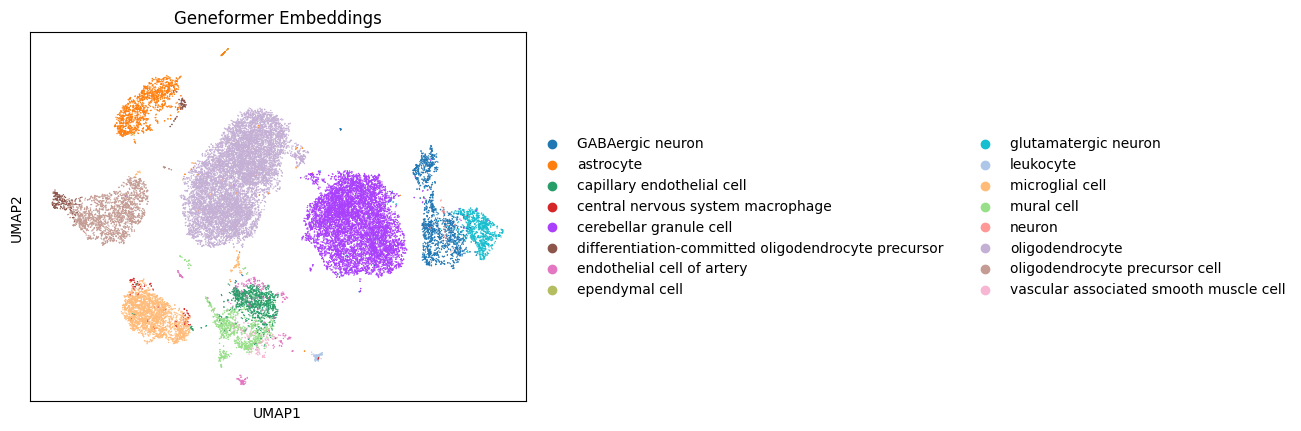

In [5]:
# Compute the nearest neighbor graph using the precomputed "geneformer" embeddings.
# This step identifies similar cells based on their Geneformer representations,
# which will be used later by UMAP to generate a low-dimensional (2D) visualization.
sc.pp.neighbors(adata, use_rep="geneformer")

# Compute the UMAP embedding based on the neighbor graph.
# UMAP reduces the high-dimensional gene expression space into a 2D space for visualization.
sc.tl.umap(adata)

# Plot UMAP based on embeddings and color them by cell type.
sc.pl.umap(adata, color="cell_type", title="Geneformer Embeddings")

In [6]:
print(f'There are {adata.obs.cell_type.unique().shape[0]} different cell types in the dataset.')
adata.obs.cell_type.value_counts()

There are 16 different cell types in the dataset.


cell_type
oligodendrocyte                                        10924
cerebellar granule cell                                 8678
microglial cell                                         2562
oligodendrocyte precursor cell                          2036
GABAergic neuron                                        1744
astrocyte                                               1557
mural cell                                              1076
capillary endothelial cell                              1072
glutamatergic neuron                                     996
endothelial cell of artery                               336
differentiation-committed oligodendrocyte precursor      306
vascular associated smooth muscle cell                   158
leukocyte                                                146
central nervous system macrophage                        110
neuron                                                    52
ependymal cell                                            27
Name: count, d

We will pass the cell types as str in the model to tokenize generate text embedding during forward pass.

In the last step of the preprocessing let transform 'sex' and 'donor_id' (target class) into categorical features.

In [7]:
# Transform 'sex' into a binary categorical feature
adata.obs, sex_mapping = to_categorical(adata.obs, "sex")

# Transform 'donor_id' into a categorical feature with more than two labels
adata.obs, class_mapping = to_categorical(adata.obs, "donor_id")

# Verify the transformation
print('Sex:', adata.obs["sex"].unique())
print('Donor_ID:', adata.obs["donor_id"].unique())

Sex: [1 0]
Donor_ID: [10  5  3  9  0  6  8  7  4  2 13 11  1 12]


In the last step of data prepration we need to gather the data as a unified dataset in PyTorch to be able to use it in the training phase. Also, we split it on train and test set to evaluate our model performance.

In [8]:
# shuffling dataset to ensure we have form all classes in both train and test
df = pd.DataFrame({
    "cell_type": adata.obs["cell_type"].values,
    "sex": adata.obs["sex"].values,
    "donor_id": adata.obs["donor_id"].values,
    "geneformer_embeddings": adata.obsm["geneformer"].tolist()
})

# Shuffle dataset while maintaining correspondence between features
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define split sizes
TRAIN_SIZE = int(0.8 * df.shape[0])

# Split shuffled data into train and test
data = {
    "cell_type": df["cell_type"][:TRAIN_SIZE].values,
    "sex": df["sex"][:TRAIN_SIZE].values,
    "geneformer_embeddings": df["geneformer_embeddings"][:TRAIN_SIZE].copy(),
    "donor_id": df["donor_id"][:TRAIN_SIZE].values
}

# Test set
data_test = {
    "cell_type": df["cell_type"][TRAIN_SIZE:].values,
    "sex": df["sex"][TRAIN_SIZE:].values,
    "geneformer_embeddings": df["geneformer_embeddings"][TRAIN_SIZE:].copy().reset_index(drop=True),
    "donor_id": df["donor_id"][TRAIN_SIZE:].values
}

# Create a PyTorch dataset and dataloader
cell_dataset = CellDataset(data)    # Create an instance of the dataset
cell_dataloader = DataLoader(cell_dataset, batch_size=32, shuffle=True)

test_dataset = CellDataset(data_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Test first batch to ensure everything is working correctly
for batch in cell_dataloader:
    print(batch)
    break

{'cell_type': ['microglial cell', 'cerebellar granule cell', 'endothelial cell of artery', 'cerebellar granule cell', 'astrocyte', 'cerebellar granule cell', 'microglial cell', 'oligodendrocyte', 'microglial cell', 'cerebellar granule cell', 'cerebellar granule cell', 'oligodendrocyte precursor cell', 'GABAergic neuron', 'cerebellar granule cell', 'cerebellar granule cell', 'cerebellar granule cell', 'microglial cell', 'oligodendrocyte', 'cerebellar granule cell', 'cerebellar granule cell', 'oligodendrocyte', 'oligodendrocyte', 'cerebellar granule cell', 'cerebellar granule cell', 'microglial cell', 'oligodendrocyte', 'oligodendrocyte', 'GABAergic neuron', 'oligodendrocyte', 'oligodendrocyte', 'cerebellar granule cell', 'mural cell'], 'sex': tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1]), 'geneformer_embeddings': tensor([[ 1.4141,  0.6758,  1.5781,  ...,  0.1182,  0.3848,  0.8320],
        [ 0.3848,  0.0483,  0.6562,  ..

## Multimodal Integration & Multimodal Pretraining

I have all my models implemented in the `utils.model` as I wanted to ensure a clean and modular reusable code. My models are as follows:

- **Text Encoder**: Contains the pretrained text encoder. It will transform `cell_type` labels into a single vector representing the label.
- **CrossModalAttention**: An internal module used by parent module as a component to integrate different modalities by applying MultiHeadAttenion and Perciever Resmaple to map them to a new shared space.
- **FusionModel**: This a intermediate model that is used in the pretraining phase to generate embeddings for modalities in the new shared space and optimizing it using a contrastive learning loss.
- **UnifiedMultiModalClassifier**: An extension of FusionModel that can load pretrained weights from the pretraining phase and accept additional features (e.g. sex feature) to train out classifier for `donor_id` predicition.

### FusionModel
The primary and most important class in `model.py` is the `FusionModel` which apply perciever resampler and attention on both text and gene embeddings to map them into a shared space. The model:
1. Gets two modality with different dimensions
2. Resamples them into a similar dimension by using projection layer
3. Applies MultiHeadAttion to both modalities to reweight them by attending to each other.

-----

**Question: Justify your choice of key, query, and value in cross-attention modules.**

The choice of key, query, and value in cross-attention modules is based on the idea of asking a question by querying a vector. In other words, we aim to reweight one set of vectors by attending to another.

In my design, I applied cross-attention to both modalities by using the attention mechanism in two ways:
1.	Treating the text embeddings as the query and the gene embeddings as the key/value.
2.	Reversing the roles, with the gene embeddings as the query and the text embeddings as the key/value.

This bidirectional approach allows both modalities to influence each other effectively.


**Effect of Cross-Attention with Single Vectors per Modality**

A key consideration in my design is that each modality is represented by a single vector rather than a sequence of vectors. This structure has notable implications for the attention mechanism:
- Since there is only one query and one key, the attention score reduces to a scalar value.
- This scalar attention weight determines how much the value vector contributes to the final output.
- Unlike standard cross-attention in transformer models, where multiple keys compete for attention, in this case, the mechanism acts as a simple reweighting function rather than a selective feature extraction process.

Despite this limitation, cross-attention still provides a way to modulate the importance of one modality’s features based on another. The interaction allows the model to adjust the representation dynamically, rather than treating the two embeddings as static features.

In [9]:
def nevative_sampler_collate(batch):
    negative_samples = generate_negative_samples(batch, "cell_type", df.cell_type.unique())
    batch = batch + negative_samples
    return {
        "cell_type": [item["cell_type"] for item in batch],
        "geneformer_embeddings": torch.stack([item["geneformer_embeddings"].clone().detach() for item in batch]),
    }
    
contrastive_loader = DataLoader(
    cell_dataset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=nevative_sampler_collate,
)

contrastive_test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=nevative_sampler_collate,
)

### Hyperparameter Estimation

In [ ]:
import optuna
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

# Define objective function for parameters
def objective(trial):
    # Defining hyperparameters that we need to tune!
    hidden_size = trial.suggest_int("hidden_size", 128, 512, step=128)
    attention_heads = trial.suggest_int("attention_heads", 1, 8)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    # Set log to True to ensure balance search for LR
    # Smaller values (like 1e-5, 2e-5) change the model behavior less than larger values (like 5e-4, 1e-3).
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    model = FusionModel(
        text_encoder_id="dmis-lab/biobert-v1.1",
        gene_input_dim=len(df['geneformer_embeddings'][0]),  
        hidden_size=hidden_size,
        freeze_text_encoder=True,
        attention_heads=attention_heads,
        dropout=dropout,
    )

    # Defining loss function, optimizer, and scheduler
    contrastive_loss = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(contrastive_loader))

    # Initialize my custom trainer
    pretrain_trainer = PretrainTrainer(
        model=model, 
        loss_fn=contrastive_loss, 
        optimizer=optimizer, 
        scheduler=scheduler
    )

    # Train the model for a small number of epochs (for efficiency)
    pretraining_metrics = pretrain_trainer.train(
        train_loader=contrastive_loader,
        val_loader=test_dataloader,
        num_epochs=2,           # More epochs results in more accurate estimation
        logging_steps=10,
    )

    # Return the validation loss
    return pretraining_metrics["validation"][-1]["val_loss"]  

# Run Bayesian Optimization
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)

[I 2025-03-04 14:23:06,732] A new study created in memory with name: no-name-aa9f312e-4d76-49fd-a3a1-b2c21bd556fa
/var/folders/pt/10ztkbv91f148th2zk5nn52w0000gn/T/ipykernel_91693/3658189934.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/var/folders/pt/10ztkbv91f148th2zk5nn52w0000gn/T/ipykernel_91693/3658189934.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
Epoch 2/2: 100%|██████████| 1589/1589 [01:22<00:00, 19.20it/s, loss=0.0187]
[I 2025-03-04 14:26:34,210] Trial 0 finished with value: 0.16091259857218468 and parameters: {'hidden_size': 128, 'attention_

In [10]:
model = FusionModel(
        text_encoder_id = "dmis-lab/biobert-v1.1",
        gene_input_dim = len(df['geneformer_embeddings'][0]),  # Geneformer embeddings shape
        hidden_size = 256,
        freeze_text_encoder = True,
        attention_heads= 2,
        # internal_attn = True,
    )
contrastive_loss = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(contrastive_loader))

pretrain_trainer = PretrainTrainer(
    model=model, 
    loss_fn=contrastive_loss, 
    optimizer=optimizer, 
    scheduler=scheduler
)

pretraining_metrics = pretrain_trainer.train(
    train_loader=contrastive_loader,
    val_loader=contrastive_test_loader,
    num_epochs=2,
    logging_steps=10,
)

Epoch 2/2: 100%|██████████| 1589/1589 [01:22<00:00, 19.25it/s, loss=0.0115] 


Now let's save the pretrained weights to use it later!

In [ ]:
# torch.save(model.state_dict(), 'weights/pretrained.pth')
pretrain_trainer.save_model('weights/pretrained/')

RuntimeError: Parent directory weights/pretrained does not exist.

Let's check if the pretrained model is working as expected and whether two embeddings are falling same place next to each other.

In [13]:
test_df = pd.DataFrame(data_test)
test_df

,cell_type,sex,geneformer_embeddings,donor_id
0,oligodendrocyte,1,"[-0.01177978515625, 0.84765625, 1.3203125, 0.9...",9
1,oligodendrocyte,0,"[-0.255859375, 1.4609375, 1.0546875, 0.5273437...",6
2,cerebellar granule cell,1,"[0.671875, -0.27734375, 1.109375, 1.0078125, 0...",13
3,oligodendrocyte,0,"[-0.099609375, 1.75, 1.2890625, 1.15625, 0.244...",6
4,oligodendrocyte,0,"[-0.333984375, 1.421875, 0.9609375, 1.1796875,...",6
...,...,...,...,...
6351,oligodendrocyte,1,"[0.134765625, 1.1640625, 1.3671875, 1.2421875,...",4
6352,oligodendrocyte,0,"[0.1962890625, 1.2734375, 0.48828125, 1.1875, ...",6
6353,oligodendrocyte,1,"[-0.462890625, 0.48828125, 1.3359375, 0.287109...",10
6354,cerebellar granule cell,0,"[-0.083984375, 0.4609375, 0.390625, 0.4765625,...",1


In [14]:
def balanced_sample(df, target_column, n_per_class=None):
    """
        Sample from a DataFrame such that each class has the same number of samples.
    """
    value_counts = df[target_column].value_counts()
    
    if n_per_class is None:
        n_per_class = value_counts.min()
    elif n_per_class > value_counts.min():
        print(f"Warning: n_per_class ({n_per_class}) is greater than the minimum class frequency ({value_counts.min()})")
        print(f"Using {value_counts.min()} instead")
        n_per_class = value_counts.min()
    
    # Sample equal number from each class
    samples = []
    for value in value_counts.index:
        class_df = df[df[target_column] == value]
        samples.append(class_df.sample(n_per_class, random_state=42))
    
    balanced_df = pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df


In [15]:
samples = balanced_sample(test_df, "cell_type", n_per_class=2)
samples.cell_type.value_counts()

cell_type
GABAergic neuron                                       2
astrocyte                                              2
capillary endothelial cell                             2
central nervous system macrophage                      2
cerebellar granule cell                                2
differentiation-committed oligodendrocyte precursor    2
endothelial cell of artery                             2
ependymal cell                                         2
glutamatergic neuron                                   2
leukocyte                                              2
microglial cell                                        2
mural cell                                             2
neuron                                                 2
oligodendrocyte                                        2
oligodendrocyte precursor cell                         2
vascular associated smooth muscle cell                 2
Name: count, dtype: int64

In [16]:
# Inference and genearate embeddings and store them in a list
triplets = []
for i, row in samples.iterrows():
    label = row['cell_type']
    input_ = ([label], torch.tensor(row['geneformer_embeddings']).unsqueeze(0).to('mps'))
    emb1, emb2 = model(input_)
    triplets.append([label, emb1.detach().cpu()[0], emb2.detach().cpu()[0]])

In [17]:
def plot_triplet_umap(triplets):
    """
    Reduces dimensionality of triplet embeddings (emb1, emb2) using UMAP and plots them.

    Parameters:
    - triplets: List of tuples (label, emb1, emb2), where:
      - label: class/category
      - emb1: first modality embedding
      - emb2: second modality embedding
    """
    labels, emb1_list, emb2_list = zip(*triplets)

    # Convert to NumPy arrays
    emb1_array = np.array(emb1_list)
    emb2_array = np.array(emb2_list)

    # Stack embeddings together for joint UMAP reduction
    all_embeddings = np.vstack([emb1_array, emb2_array])

    # Reduce to 2D using UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(all_embeddings)

    # Separate reduced embeddings
    emb1_reduced = reduced_embeddings[:len(emb1_list)]
    emb2_reduced = reduced_embeddings[len(emb1_list):]

    # Plot setup
    plt.figure(figsize=(10, 7))
    sns.set(style="whitegrid")

    # Unique classes for color mapping
    unique_classes = np.unique(labels)
    palette = sns.color_palette("husl", len(unique_classes))
    class_to_color = {cls: palette[i] for i, cls in enumerate(unique_classes)}

    # Plot embeddings with corrected color and marker
    for i, cls in enumerate(labels):
        plt.scatter(*emb1_reduced[i], color=class_to_color[cls], marker='o', label=cls if i == 0 else "", alpha=0.7)  # emb1 (o)
        plt.scatter(*emb2_reduced[i], color=class_to_color[cls], marker='s', label=cls if i == 0 else "", alpha=0.7)  # emb2 (s)

    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.title("UMAP Projection of Multi-modal Embeddings")

    # Custom legend for markers
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Text Embedding'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Gene Embedding')
    ]
    plt.legend(handles=legend_elements, title="Modality", loc="lower right", bbox_to_anchor=(1.15, 1))
    plt.savefig('logs/pretrained_umap.png', dpi=600, bbox_inches='tight', format='png')
    plt.show()

/Users/pouyannahed/opt/anaconda3/envs/czbiohub/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


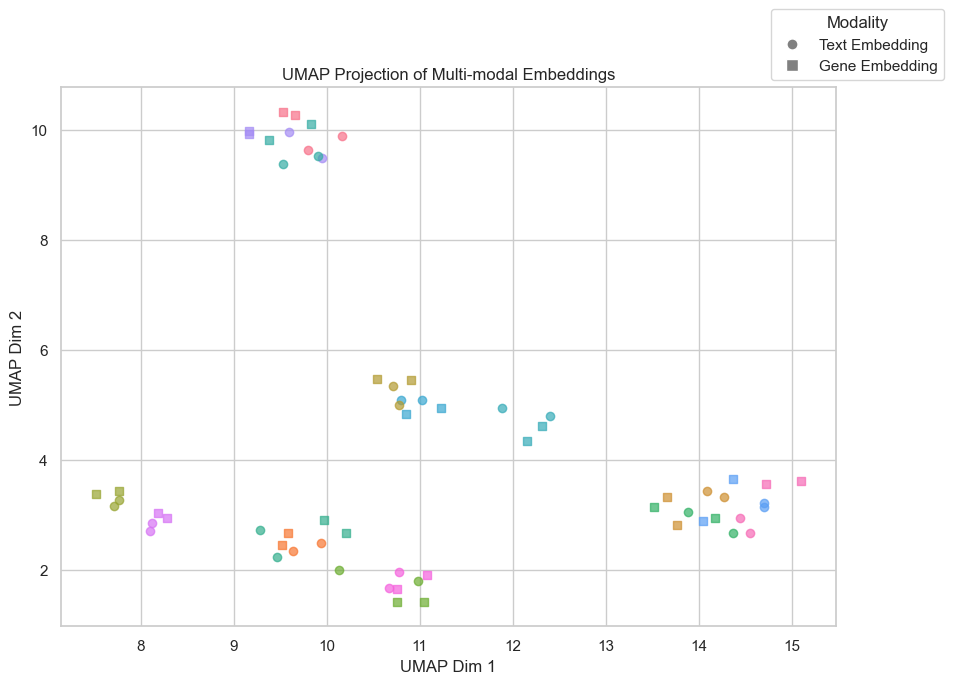

In [18]:
plot_triplet_umap(triplets)

In the plot modals are represented by different markers (cirlce for text and square for gene) and colors are unique for each cell_type. We can see that the model is able to encode and have a shared space pretty well! The distances are not ideal but still we can cleary see the separation between classes.

## Train Classifier

Now lets initialize a model for classification and use our pretrained model to classify the `donor_id`. For this task I have designed and implemented a Module called `UnifiedMultiModalClassifier` in the `model.py` which is exntension of the last `FusionModel` with a classification head that classifies and predicts `donor_id`.

In [ ]:
classifier = UnifiedMultiModalClassifier(
    class_num=df['donor_id'].unique().shape[0]
)

# Load pretrained weights!
classifier.from_pretrained('weights/pretrained/model.pth')

In [20]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
ce_loss = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(cell_dataloader))

classification_trainer = StandardTrainer(
    model=classifier,
    optimizer=optimizer,
    loss_fn=ce_loss,
    scheduler=scheduler,
)

classifier_train_metrics = classification_trainer.train(
    cell_dataloader,
    num_epochs=3,
    logging_steps=10,
    val_loader=test_dataloader,
)


Epoch 3/3: 100%|██████████| 795/795 [00:39<00:00, 19.96it/s, loss=1.61]


### Test Classifier

In [ ]:
def inference(model, dataloader, device=None):
    """
    Perform inference on the given dataloader and return the model predictions.
    """
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:    
            device = "cpu"
        device = torch.device(device)
    
    model.to(device)
    model.eval()  # Set model to evaluation mode (disable some modules like dropout)

    gt_labels = []
    predictions = []
    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(dataloader, total=len(dataloader)):
            # Convert cell_type strings to indices using the vocabulary mapping
            cell_type_list = batch["cell_type"]
            gene_data = batch["geneformer_embeddings"].to(device)
            if 'sex' in batch:
                sex = batch['sex'].to(device)
                input_ = (cell_type_list, gene_data, sex)
            else:
                input_ = (cell_type_list, gene_data)

            output = model(input_)
            predictions.append(output.cpu())  # Move to CPU for easier processing
            gt_labels.append(batch['donor_id'].cpu())  # Move to CPU for easier processing

    return torch.cat(predictions), torch.cat(gt_labels)  # Concatenate all predictions & labels

In [ ]:
y_pred, y_true = inference(
    classifier,
    test_dataloader,
)
y_pred = F.softmax(y_pred, dim=1).argmax(1)

print(classification_report(y_true, y_pred))
print('Model Accuracy: {:.3f}%'.format(accuracy_score(y_true, y_pred) * 100))
sns.heatmap(confusion_matrix(y_true, y_pred), label=[class_mapping[i] for i in len(class_mapping)])

              precision    recall  f1-score   support

           0       0.45      0.52      0.48       439
           1       0.54      0.67      0.60       480
           2       0.52      0.11      0.18       288
           3       0.74      0.72      0.73       193
           4       0.50      0.61      0.55       663
           5       0.52      0.30      0.38       381
           6       0.71      0.76      0.73       687
           7       0.38      0.43      0.40       569
           8       0.62      0.66      0.64       544
           9       0.48      0.63      0.54       412
          10       0.16      0.02      0.04       201
          11       0.53      0.32      0.40       332
          12       0.57      0.57      0.57       359
          13       0.72      0.82      0.77       808

    accuracy                           0.56      6356
   macro avg       0.53      0.51      0.50      6356
weighted avg       0.55      0.56      0.54      6356

Model Accuracy: 56.388%


<Axes: >

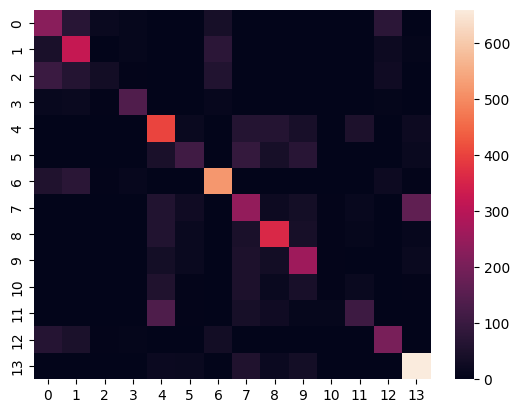

In [29]:
print(classification_report(y_true, y_pred))
print('Model Accuracy: {:.3f}%'.format(accuracy_score(y_true, y_pred) * 100))
sns.heatmap(confusion_matrix(y_true, y_pred))